### Detect overlapping between two ellipses

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Ellipse

#### The Ellipse Equation: (https://en.wikipedia.org/wiki/Ellipse#General_ellipse , but swapping B and C)

$$
A x^2 + B y^2 + C x y +  D x +  E y + F = 0
$$
where 

$
\begin{align}
A & = a^2\sin^2{\theta} +  b^2\cos^2{\theta},  \\
B & = a^2\cos^2{\theta} +  b^2\sin^2{\theta}, \\
C & = 2(b^2 - a^2)\sin{\theta}\cos{\theta}, \\
D & = -2Ax_0 - Cy_0,  \\
E & = -C x_0 - 2B y_0,  \\
F & = Ax_0^2 + C x_0 y_0 + By_0^2 - a^2 b^2. 
\end{align}
$

#### following the definitions of https://www.sciencedirect.com/science/article/abs/pii/S0167839617300791 (hereafter AC2017):  
shrink the parameters CDE by half,

$$ C = C / 2, \quad D = D / 2, \quad E = E / 2, $$

and modify the Ellipse Equation:

$$
A x^2 + B y^2 + 2C x y + 2 D x + 2 E y + F = 0.
$$

#### To get the Ellipse parameters ABCDEF from the Extragalactic Catalog:

#### To get the Ellipse parameters ABCDEF from the Object Catalog:
based on my calculation, for perfect ellipses,
$$ 
\begin{align}
I_{xx} & = \frac{\pi}{4}ab \left( a^2\cos^2{\theta} + b^2\sin^2{\theta} \right), \\
I_{yy} & = \frac{\pi}{4}ab \left( a^2\sin^2{\theta} + b^2\cos^2{\theta} \right), \\ 
I_{xy} & = \frac{\pi}{4}ab \left( a^2 - b^2 \right) \cos{\theta}\sin{\theta}.
\end{align}
$$
therefore,
$$ 
\begin{align}
I_{xx}I_{yy} - I^2_{xy} 
    & = \frac{\pi^2}{16}a^2 b^2 
    \left[ \left( a^2\cos^2{\theta} + b^2\sin^2{\theta} \right) 
    \left( a^2\sin^2{\theta} + b^2\cos^2{\theta} \right) -
    \left( a^2 - b^2 \right)^2 \cos^2{\theta}\sin^2{\theta} \right] \\
    & = \frac{\pi^2}{16}a^4 b^4
\end{align}
$$
or

$ \pi ab = 2\sqrt{\pi} \left( I_{xx}I_{yy} - I^2_{xy} \right)^{1/4}. $

Furthermore, 

$
\begin{align}
A & = a^2\sin^2{\theta} +  b^2\cos^2{\theta} = \frac{4I_{yy}}{\pi ab},  \\
B & = a^2\cos^2{\theta} +  b^2\sin^2{\theta} = \frac{4I_{xx}}{\pi ab}, \\
C & = 2(b^2 - a^2)\sin{\theta}\cos{\theta} = \frac{-8I_{xy}}{\pi ab}, \\ 
\end{align}
$

and D, E, F follows.

In [8]:
def ellipse_equation(x, y, A, B, C, D, E, F):
    return A*x**2 + B*y**2 + 2*C*x*y + 2*D*x + 2*E*y + F

def is_overlapping(p1, p2):
    A1, B1, C1, D1, E1, F1 = p1
    A2, B2, C2, D2, E2, F2 = p2
    
    M1 = [[A1, C1, D1], [C1, B1, E1], [D1, E1, F1]]
    M2 = [[A2, C2, D2], [C2, B2, E2], [D2, E2, F2]]
    
    l0 = np.linalg.det(M2)
    l1 = (np.linalg.det([[A1,C2,D2],[C1,B2,E2],[D1,E2,F2]]) +
            np.linalg.det([[A2,C1,D2],[C2,B1,E2],[D2,E1,F2]]) +
            np.linalg.det([[A2,C2,D1],[C2,B2,E1],[D2,E2,F1]])) / 3
    l2 = (np.linalg.det([[A2,C1,D1],[C2,B1,E1],[D2,E1,F1]]) +
            np.linalg.det([[A1,C2,D1],[C1,B2,E1],[D1,E2,F1]]) +
            np.linalg.det([[A1,C1,D2],[C1,B1,E2],[D1,E1,F2]])) / 3
    l3 = np.linalg.det(M1)

    delta1 = np.linalg.det([[l3, l2],[l2, l1]])
    delta2 = np.linalg.det([[l3, l1],[l2, l0]])
    delta3 = np.linalg.det([[l2, l1],[l1, l0]])
    discriminant_P = np.linalg.det([[2*delta1, delta2], [delta2, 2*delta3]])
    
    if (discriminant_P >=0) and ((l1>0) or (l2>0)):
        return False  ## not over-lapping
    else:
        return True

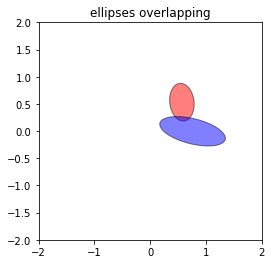

In [14]:
x1, y1 = np.random.uniform(-1,1,2)  ## center of ellipse 1
a1, b1 = np.random.uniform(0,1,2)
theta1 = np.random.uniform(0, np.pi)
if b1 > a1:
    a1, b1 = b1, a1

x2, y2 = np.random.uniform(-1,1,2)  ## center of ellipse 2
a2, b2 = np.random.uniform(0,1,2)
theta2 = np.random.uniform(0, np.pi)
if b2 > a2:
    a2, b2 = b2, a2

sin1 = np.sin(theta1)
sin2 = np.sin(theta2)

cos1 = np.cos(theta1)
cos2 = np.cos(theta2)

A1 = (a1*sin1)**2 + (b1*cos1)**2
A2 = (a2*sin2)**2 + (b2*cos2)**2

B1 = (a1*cos1)**2 + (b1*sin1)**2
B2 = (a2*cos2)**2 + (b2*sin2)**2

C1 = 2*(b1**2 - a1**2)*sin1*cos1
C2 = 2*(b2**2 - a2**2)*sin2*cos2

D1 = -2*A1*x1 - C1*y1
D2 = -2*A2*x2 - C2*y2

E1 = -C1*x1 - 2*B1*y1
E2 = -C2*x2 - 2*B2*y2

F1 = A1*x1**2 + C1*x1*y1 + B1*y1**2 - (a1*b1)**2
F2 = A2*x2**2 + C2*x2*y2 + B2*y2**2 - (a2*b2)**2

C1, D1, E1 = C1/2, D1/2, E1/2
C2, D2, E2 = C2/2, D2/2, E2/2

p1 = [A1, B1, C1, D1, E1, F1]
p2 = [A2, B2, C2, D2, E2, F2]

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111, xlim=(-2,2), ylim=(-2,2))

ellipse1 = Ellipse((x1,y1), width=2*a1, height=2*b1, angle=np.degrees(theta1), facecolor='r', edgecolor='k', alpha=0.5, linewidth=1)
ellipse2 = Ellipse((x2,y2), width=2*a2, height=2*b2, angle=np.degrees(theta2), facecolor='b', edgecolor='k', alpha=0.5, linewidth=1)
ax1.add_artist(ellipse1)
ax1.add_artist(ellipse2)

if is_overlapping(p1, p2):
    ax1.set_title('ellipses overlapping')
else:
    ax1.set_title('not overlapping')

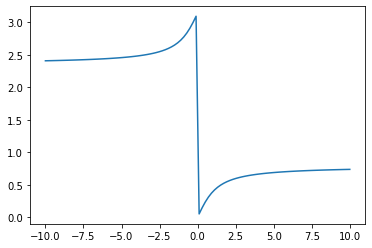

In [17]:
ratio = np.linspace(-10, 10 ,100)
theta = np.arctan(ratio)/2

for i, t in enumerate(theta):
    if t < 0:
        theta[i] += np.pi

plt.plot(ratio, theta)